# TODO Needs Comments


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import seaborn as sns
from sklearn import model_selection


mpl.rcParams['figure.dpi'] = 300


# Configuring paths and loading raw data
home_directory = r"D:\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
table_location = home_directory + "tabular_data"

translation_frame = pd.read_csv("translation_dataframe_timepoints.csv")
name_mapping = {key:new_key for key,new_key in zip(translation_frame["original_names"],translation_frame["plot_names"])}

data = pd.read_csv(f"{table_location}/All_Samples_Feature_Space_All_Features_48h,72h,96h_Normalised_per_Timepoint.csv")

# Adding Annotations to Data
annotations = table_location + "/annotations_with_indices.csv"
annotation_df = pd.read_csv(annotations)
mapping = {"Real_Run":"RR", "Trial_Run":"TR"}
annotation_df["Run"] = [mapping[value] for value in annotation_df["Run"].to_numpy()]
no_na_annot = annotation_df[annotation_df["Morph_Class"]!="NA_NA"]
data_annotated = data.set_index(["Run","Plate","ID"]).merge(no_na_annot,on=["Run","Plate","ID"])

# Filtering to relevant dataset
dat_axes = data_annotated[data_annotated["Axes"] != "unclassified"]
dat_axes = dat_axes[dat_axes['048h_raw_BF_AreaShape_area'].notna()].dropna(axis=1).dropna()
dat_axes = dat_axes.drop([key for key in dat_axes.keys() if any([term in key for term in ["Location","orientation","_X","_Y","UMAP","PC"]])],axis=1) #,
counts = dat_axes.groupby("Axes")["Run"].count()
print(counts)


dat_axes

Axes
double    136
single    256
Name: Run, dtype: int64


,Run,Plate,ID,048h_raw_BF_AreaShape_area,048h_raw_BF_AreaShape_aspect_ratio,048h_raw_BF_AreaShape_axis_major_length,048h_raw_BF_AreaShape_axis_minor_length,048h_raw_BF_AreaShape_eccentricity,048h_raw_BF_AreaShape_feret_diameter_max,048h_raw_BF_AreaShape_perimeter,...,096h_str_BF_AreaShape_moments_hu_3,096h_str_BF_AreaShape_moments_hu_4,096h_str_BF_AreaShape_moments_hu_5,096h_str_BF_AreaShape_moments_hu_6,096h_str_BF_AreaShape_perimeter,096h_str_CH_AreaShape_Bra_MajorAxis_Polarisation,096h_str_CH_AreaShape_Bra_MinorAxis_Polarisation,Axes,Morph,Morph_Class
0,RR,1,A1,0.754091,-0.889636,0.132588,1.204628,-1.000051,0.007074,0.615519,...,-0.188818,-0.081040,-0.108285,-0.018937,0.485603,-0.237483,0.204173,single,good,single_good
1,RR,1,A2,-0.783470,-1.252670,-1.238409,0.003129,-1.752936,-1.131530,-0.724230,...,-0.142104,-0.080919,-0.108023,0.017986,-0.276812,-0.930821,1.071650,single,bad,single_bad
2,RR,1,A3,1.636441,-0.184192,1.186196,1.565451,-0.008740,1.127225,1.795347,...,-0.186519,-0.081045,-0.108504,-0.019001,0.014028,0.406917,-0.068697,single,bad,single_bad
3,RR,1,A4,-0.525754,-0.513477,-0.672134,-0.202863,-0.422446,-0.849309,-0.402853,...,0.038707,-0.073034,-0.013521,0.038021,0.652506,0.992505,-0.551399,single,good,single_good
4,RR,1,A5,0.537872,-0.248943,0.294790,0.612413,-0.084969,0.059492,0.498737,...,-0.161387,-0.081127,-0.113141,-0.013480,-1.090064,0.285818,-0.643907,single,bad,single_bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,TR,2,H6,-0.425288,-0.307064,-0.483649,-0.222631,-0.155368,-0.286443,-0.402853,...,-0.148319,-0.080284,-0.104770,-0.006234,1.987318,-1.297863,-1.038224,double,unclassified,double_unclassified
434,TR,2,H9,-0.925432,1.281638,-0.116354,-1.536867,1.304509,-0.330223,-1.009869,...,-0.018204,-0.084586,-0.137911,0.247706,1.965908,0.143556,0.712064,single,good,single_good
435,TR,2,H10,-1.873304,-1.279234,-2.131125,-1.049808,-1.821515,-2.016265,-1.929328,...,-0.117763,-0.082320,-0.115499,0.052699,1.923294,-1.128242,-0.816051,double,unclassified,double_unclassified
436,TR,2,H11,-2.408392,-0.915375,-2.411391,-1.803167,-1.045366,-2.414625,-2.306480,...,0.161155,-0.101456,-0.309307,0.338411,1.652660,-0.982778,1.840169,single,good,single_good


# First Lets See How Much Normal PLSR Differs from Randomised PLSR

In [2]:
gt_keys = ["Run","Plate","ID","Axes","Morph","Morph_Class"]
X = dat_axes.drop(gt_keys,axis=1)
Y = pd.get_dummies(dat_axes["Axes"])["single"]
Y

0       True
1       True
2       True
3       True
4       True
       ...  
431    False
434     True
435    False
436     True
437    False
Name: single, Length: 392, dtype: bool

In [3]:
# fit the regular pls regression
my_plsr = PLSRegression(n_components=2, scale=False)
my_plsr.fit(StandardScaler().fit_transform(X), Y)

# extract scores (one score per individual per component)
scores_df = pd.DataFrame(my_plsr.x_scores_)

# standardize scores between -1 and 1 so they fit on the plot
std_scores_dim1 = 2 * ( (scores_df[0] - min(scores_df[0])) / (max(scores_df[0]) - min(scores_df[0])) ) -1
std_scores_dim2 = 2 * ( (scores_df[1] - min(scores_df[1])) / (max(scores_df[1]) - min(scores_df[1])) ) -1


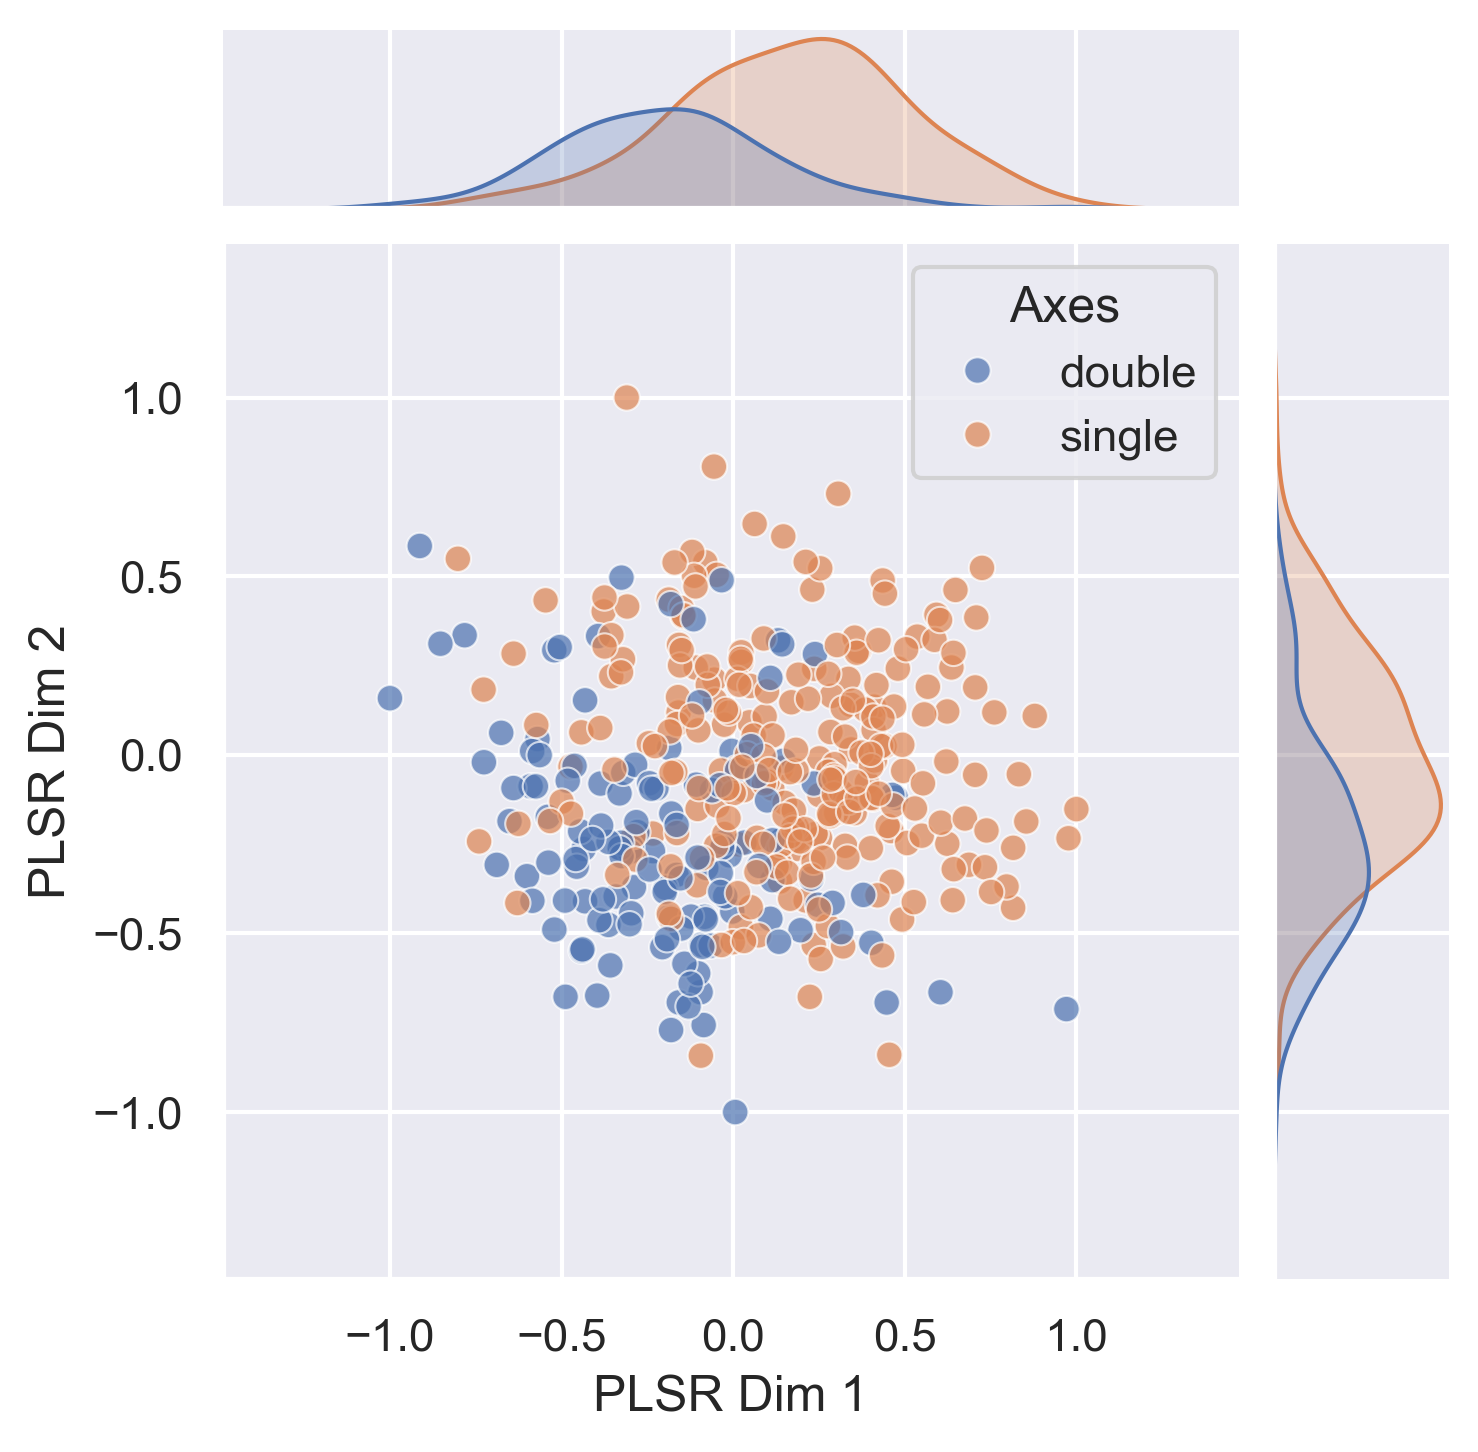

In [4]:
sns.set()

df_components = pd.DataFrame(
    {
        "Axes":dat_axes["Axes"].to_numpy(),
        "single":Y.to_numpy().astype(bool),
        "PLSR Dim 1":std_scores_dim1,
        "PLSR Dim 2":std_scores_dim2,
    }
)

sns.jointplot(df_components,x="PLSR Dim 1",y="PLSR Dim 2",hue="Axes", **{"alpha":0.7,"s":40},height=5,hue_order=["double","single"])
plt.show()

In [5]:
# randomised labels
random_X = np.array(X)[np.random.choice(len(X), size = len(X),replace = False)]

# fit randomised plsr
my_plsr_random = PLSRegression(n_components=2, scale=False)
my_plsr_random.fit(StandardScaler().fit_transform(random_X), Y)

# extract scores (one score per individual per component)
scores_df_random = pd.DataFrame(my_plsr_random.x_scores_)

# standardize scores between -1 and 1 so they fit on the plot
std_random_scores_dim1 = 2 * ( (scores_df_random[0] - min(scores_df_random[0])) / (max(scores_df_random[0]) - min(scores_df_random[0])) ) -1
std_random_scores_dim2 = 2 * ( (scores_df_random[1] - min(scores_df_random[1])) / (max(scores_df_random[1]) - min(scores_df_random[1])) ) -1

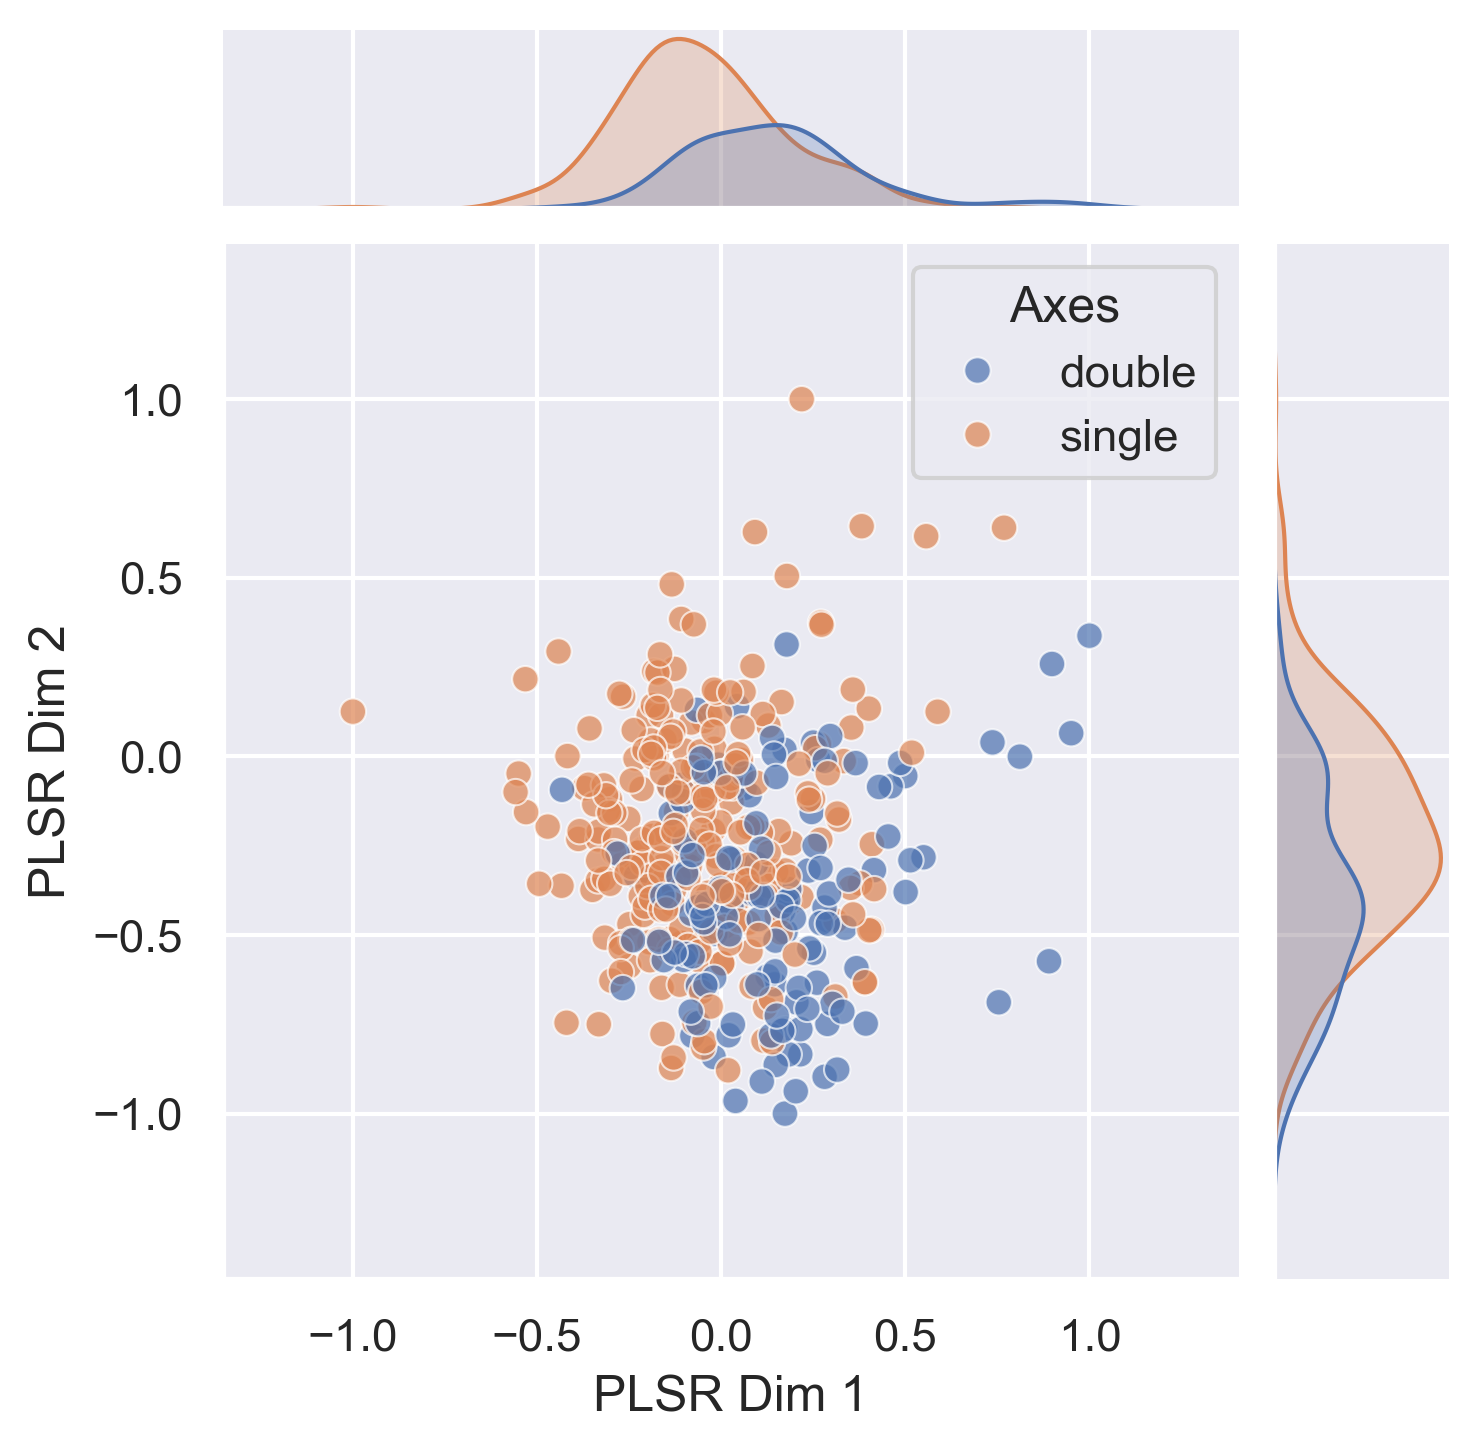

In [6]:
df_components = pd.DataFrame(
    {
        "Axes":dat_axes["Axes"].to_numpy(),
        "single":Y.to_numpy().astype(bool),
        "PLSR Dim 1":std_random_scores_dim1,
        "PLSR Dim 2":std_random_scores_dim2,
    }
)

sns.jointplot(df_components,x="PLSR Dim 1",y="PLSR Dim 2",hue="Axes", **{"alpha":0.7,"s":40},height=5,hue_order=["double","single"])
#plt.savefig(f"{out_fig_2}/PLSR Axes components.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
df_components[df_components["single"] == True]["PLSR Dim 1"].mean() > df_components[df_components["single"] == False]["PLSR Dim 1"].mean()

False

In [8]:
# Repeating PLSR multiple times while just randomising the order of samples

np.random.seed(42)

n_to_leave_out = int(0.2*len(X))
print(n_to_leave_out)

normal_plsr_loadings = []
normal_plsr_scores = []
normal_indices = []
normal_labels = []

for i in range(100):
    random_indices = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    random_indices_2 = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    
    normal_indices.append(random_indices)
    
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(StandardScaler().fit_transform(np.array(X)[random_indices]), np.array(Y)[random_indices])
    
    normal_labels.append(np.array(Y)[random_indices])
    # extract scores (one score per individual per component)
    scores_df = pd.DataFrame(my_plsr.x_scores_,columns=["PLSR_Dim_1","PLSR_Dim_2"])
    scores_df["original_indices"] = random_indices
    scores_df["single"] = np.array(Y)[random_indices]
    normal_plsr_scores.append(scores_df.set_index("original_indices"))
    
    # extract_loadings
    loadings_df = pd.DataFrame(my_plsr.x_loadings_,index=X.columns,columns=["PLSR Dim 1","PLSR Dim 2"])
    normal_plsr_loadings.append(loadings_df)

78


In [9]:
pd.concat([df[["PLSR_Dim_1","single"]] for df in normal_plsr_scores],axis=1)

,PLSR_Dim_1,single,PLSR_Dim_1,single,PLSR_Dim_1,single,PLSR_Dim_1,single,PLSR_Dim_1,single,...,PLSR_Dim_1,single,PLSR_Dim_1,single,PLSR_Dim_1,single,PLSR_Dim_1,single,PLSR_Dim_1,single
original_indices,,,,,,,,,,,,,,,,,,,,,
78,2.130726,True,-2.421264,True,-2.069093,True,NaN,NaN,-2.422086,True,...,-2.921513,True,-1.393777,True,2.377654,True,2.750022,True,2.565409,True
274,-9.169950,True,8.357776,True,8.448280,True,-8.517981,True,8.674056,True,...,8.531983,True,NaN,NaN,-8.492767,True,-8.683163,True,NaN,NaN
246,-5.965723,True,5.751416,True,6.409034,True,-5.767704,True,5.581203,True,...,5.607571,True,6.322262,True,-5.033016,True,-5.751890,True,-5.334474,True
55,-2.754931,False,NaN,NaN,NaN,NaN,NaN,NaN,2.448209,False,...,1.851230,False,2.915291,False,NaN,NaN,-2.547287,False,-2.000776,False
387,-12.257288,False,NaN,NaN,NaN,NaN,-11.827036,False,11.423014,False,...,11.200792,False,12.029432,False,NaN,NaN,-12.123803,False,-11.964982,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,NaN,NaN,NaN,NaN,7.318883,False,-7.547247,False,7.394780,False,...,6.822100,False,7.700642,False,-6.839432,False,NaN,NaN,NaN,NaN
357,NaN,NaN,NaN,NaN,NaN,NaN,4.131803,True,-3.863127,True,...,-3.489222,True,-2.186520,True,NaN,NaN,4.147776,True,3.370331,True
169,NaN,NaN,NaN,NaN,NaN,NaN,1.286945,True,-1.766745,True,...,-2.113501,True,-1.790712,True,2.816591,True,NaN,NaN,NaN,NaN


In [10]:
# Repeating PLSR multiple times while just randomising the labels

np.random.seed(42)

random_plsr_loadings = []
random_plsr_scores = []
indices_random_1 = []
indices_random_2 = []
for i in range(100):
    random_indices = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    random_indices_2 = np.random.choice(len(X),size = len(X)-n_to_leave_out, replace=False)
    
    indices_random_1.append(random_indices)
    indices_random_2.append(random_indices_2)
    
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(StandardScaler().fit_transform(np.array(X)[random_indices]), np.array(Y)[random_indices_2])
    
    # extract scores (one score per individual per component)
    scores_df = pd.DataFrame(my_plsr.x_scores_,columns=["PLSR_Dim_1","PLSR_Dim_2"])
    scores_df["original_indices"] = random_indices
    scores_df["randomised single"] = np.array(Y)[random_indices_2]
    random_plsr_scores.append(scores_df.set_index("original_indices"))
    
    # extract_loadings
    loadings_df = pd.DataFrame(my_plsr.x_loadings_,index=X.columns,columns=["PLSR Dim 1","PLSR Dim 2"])
    random_plsr_loadings.append(loadings_df)

In [11]:
pd.concat([df[["PLSR_Dim_1","randomised single"]] for df in random_plsr_scores],axis=1)

,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single,...,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single,PLSR_Dim_1,randomised single
original_indices,,,,,,,,,,,,,,,,,,,,,
78,-5.123779,False,-2.974781,False,-4.542032,False,NaN,NaN,-4.768906,False,...,-3.096922,True,1.407563,False,-0.443285,False,-1.943723,False,-2.164181,True
274,3.637410,False,-6.938619,False,4.189259,False,5.684489,False,1.153179,False,...,-1.285932,True,NaN,NaN,5.569929,True,-1.295342,True,NaN,NaN
246,1.913772,True,-2.399698,True,4.373882,True,0.550153,False,-0.947114,False,...,0.004546,True,-3.560246,True,4.156591,True,-1.817604,True,5.150429,True
55,-4.903889,True,NaN,NaN,NaN,NaN,NaN,NaN,0.985674,False,...,-0.320039,True,4.325747,False,NaN,NaN,0.411112,True,-2.624864,False
387,9.545008,False,NaN,NaN,NaN,NaN,8.875230,False,7.560186,True,...,5.400438,True,-2.118123,True,NaN,NaN,1.496149,True,3.666772,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,NaN,NaN,NaN,NaN,4.872843,True,6.768666,True,3.108502,True,...,2.544233,False,-0.957402,True,6.541257,True,NaN,NaN,NaN,NaN
357,NaN,NaN,NaN,NaN,NaN,NaN,-5.615963,False,-7.801062,True,...,-6.579515,False,-0.734975,True,NaN,NaN,-2.356232,True,0.768358,False
169,NaN,NaN,NaN,NaN,NaN,NaN,-2.663155,False,2.876088,True,...,5.853601,False,-1.898728,False,1.178301,True,NaN,NaN,NaN,NaN


In [12]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

metrics = [davies_bouldin_score,calinski_harabasz_score,silhouette_score]

score_dataframes = []

for name,label_name,plsr_scores in zip(["Normal","Random"],["single","randomised single"],[normal_plsr_scores,random_plsr_scores]):
    
    
    separation_index = pd.DataFrame()
    separation_index["Data"] = [name for i in range(len(plsr_scores))]
    for metric in metrics:
        scores = []
        for df in plsr_scores:
            feats = df[["PLSR_Dim_1","PLSR_Dim_2"]]
            labels = df[label_name]
            score = metric(feats,labels)
            #print(score)
            scores.append(score)
        separation_index[metric.__name__] = scores
        
    score_dataframes.append(separation_index)
    
all_scores = pd.concat(score_dataframes,axis=0,ignore_index=True)
all_scores

,Data,davies_bouldin_score,calinski_harabasz_score,silhouette_score
0,Normal,1.585234,80.958397,0.181660
1,Normal,1.629741,77.693877,0.190855
2,Normal,1.588727,78.713770,0.185754
3,Normal,1.619679,77.393659,0.178921
4,Normal,1.660045,75.715618,0.179984
...,...,...,...,...
195,Random,2.605782,32.643263,0.091822
196,Random,2.209745,45.426850,0.109595
197,Random,2.173710,45.614541,0.114783
198,Random,1.958029,53.424155,0.126997


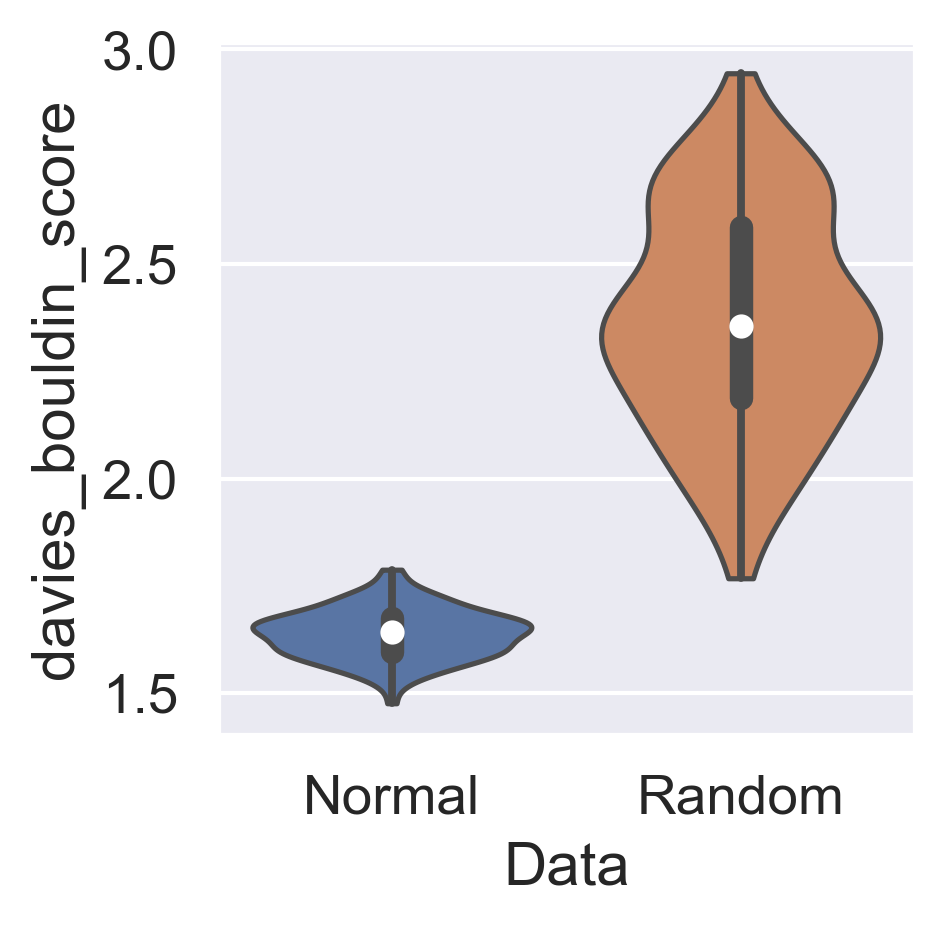

In [13]:
import os

out_revisions = r"D:\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation\Plots\Revisions"
if not os.path.isdir(out_revisions):
    os.mkdir(out_revisions)

sns.set(font_scale=1.2)
    
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="davies_bouldin_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Axes Davies Bouldin Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

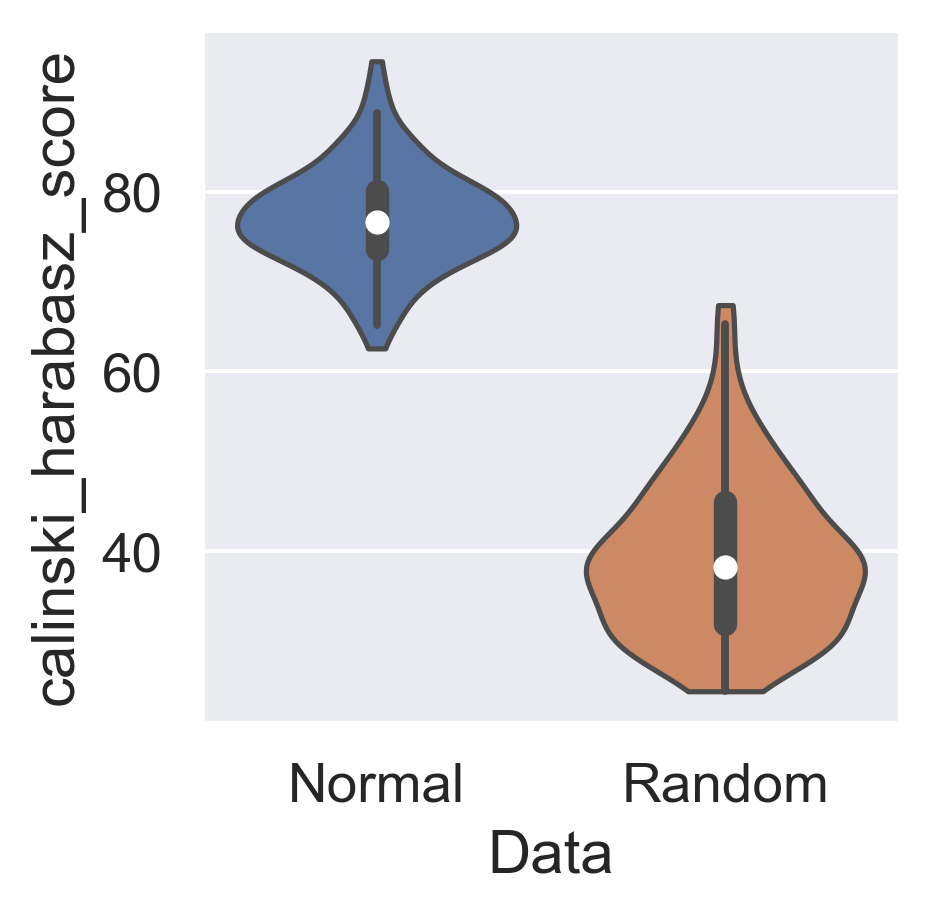

In [14]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="calinski_harabasz_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Axes Calinski Harabasz Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

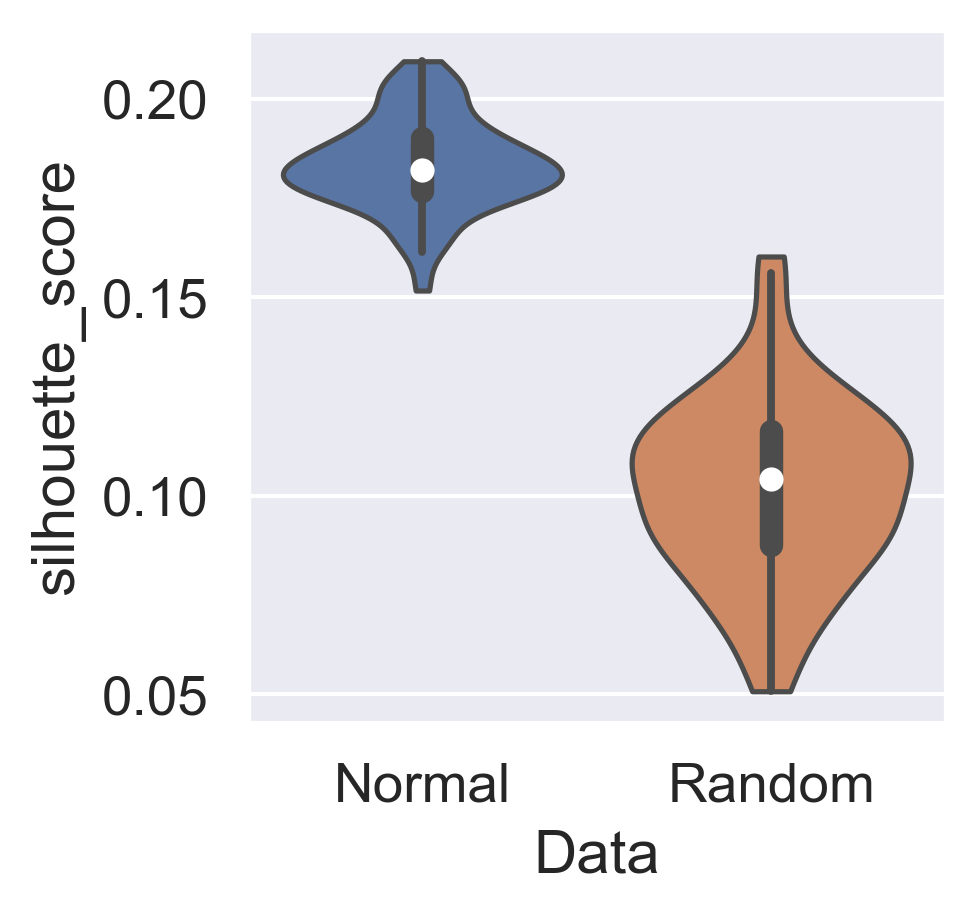

In [15]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(all_scores,x="Data",y="silhouette_score",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
plt.savefig(f"{out_revisions}/PLSR Axes Silhouette Score 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

In [16]:
score_ranks = {metric.__name__:all_scores[metric.__name__].rank(ascending=bool(flag)).to_numpy() for metric, flag in zip(metrics, [0,1,1])}
score_ranks = pd.DataFrame(score_ranks)
score_ranks["Data"] = all_scores["Data"]
score_ranks["Avg Rank"] = np.mean(score_ranks[["davies_bouldin_score","calinski_harabasz_score","silhouette_score"]].to_numpy(),axis=1)
score_ranks

,davies_bouldin_score,calinski_harabasz_score,silhouette_score,Data,Avg Rank
0,184.0,180.0,146.0,Normal,170.000000
1,158.0,156.0,177.0,Normal,163.666667
2,181.0,164.0,161.0,Normal,168.666667
3,160.0,153.0,135.0,Normal,149.333333
4,135.0,146.0,139.0,Normal,140.000000
...,...,...,...,...,...
195,24.0,29.0,35.0,Random,29.333333
196,71.0,75.0,64.0,Random,70.000000
197,78.0,77.0,71.0,Random,75.333333
198,94.0,95.0,90.0,Random,93.000000


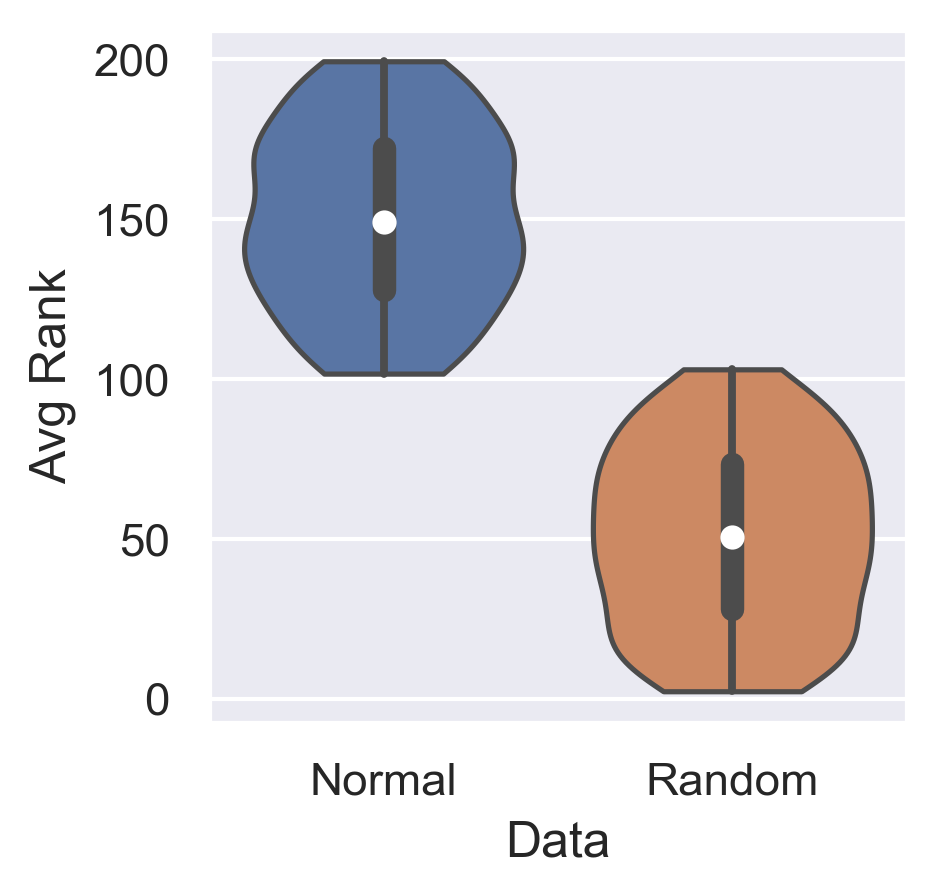

In [17]:
sns.set()

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.violinplot(score_ranks,x="Data",y="Avg Rank",ax=ax,cut=0,hue="Data",inner_kws={"marker":"o"})
#sns.stripplot(score_ranks,x="Data",y="Avg Rank",ax=ax,palette="tab10",alpha=0.7,edgecolor = "white", linewidths = 2)
plt.savefig(f"{out_revisions}/PLSR Axes avg separation rank 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

<Axes: xlabel='Data', ylabel='Avg Rank'>

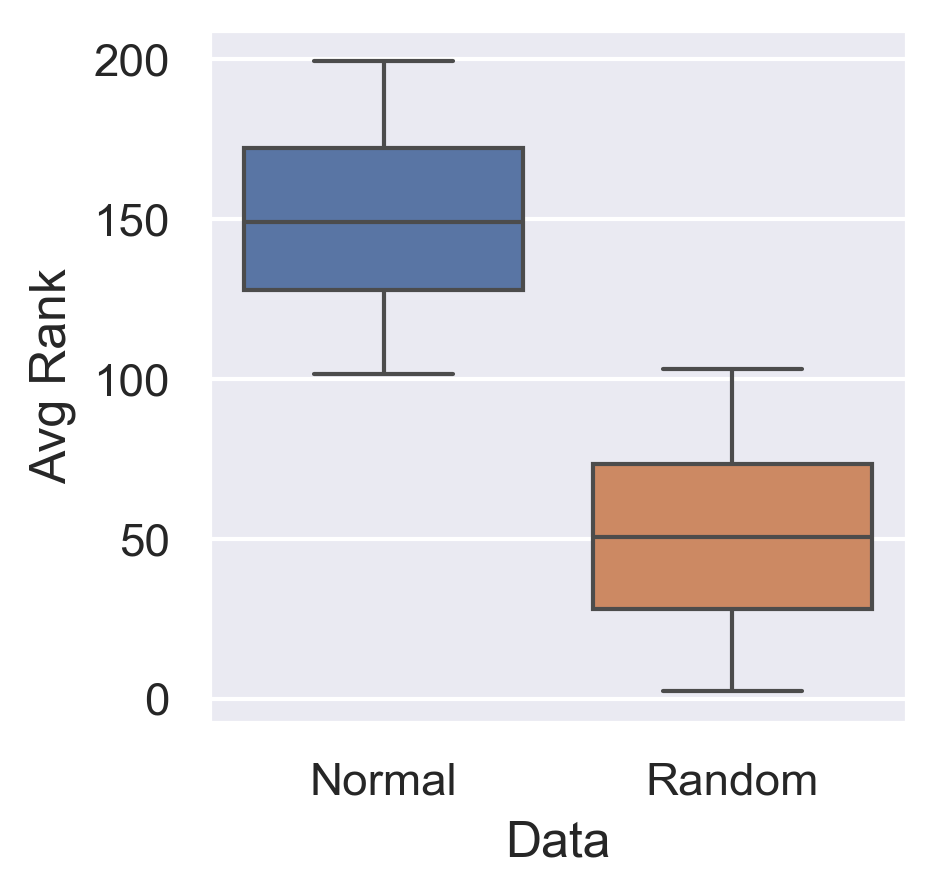

In [18]:
sns.set()

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(score_ranks,x="Data",y="Avg Rank",ax=ax, hue="Data")
#sns.stripplot(score_ranks,x="Data",y="Avg Rank",ax=ax,palette="tab10",alpha=0.7,edgecolor = "white", linewidths = 2)
#plt.savefig(f"{out_revisions}/PLSR Axes avg separation rank 100 shuffles 80% data feature loadings.pdf", format="pdf", bbox_inches="tight")

In [19]:
kfold_split = model_selection.StratifiedKFold(n_splits=5)
kfold_split.get_n_splits(X,Y)

5

In [20]:
from sklearn import metrics

all_confusion_matrices = []
all_test_y_pred_y = []
all_pred_y_nothresh = []
for i, (train_index, test_index) in enumerate(kfold_split.split(X,Y)):
    train_X, test_X, train_Y, test_Y = X.to_numpy()[train_index],X.to_numpy()[test_index],Y.to_numpy()[train_index],Y.to_numpy()[test_index]
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(np.array(train_X), np.array(train_Y))

    test_pred = (my_plsr.predict(np.array(test_X)) > 0.5)[:,0]
    matrix = metrics.confusion_matrix(test_Y,test_pred,)
    all_confusion_matrices.append(matrix)
    all_test_y_pred_y.append((test_Y,test_pred))
    all_pred_y_nothresh.append(my_plsr.predict(np.array(test_X)))

In [21]:
norm_confusion_matrices = [matrix/np.sum(matrix) for matrix in all_confusion_matrices]

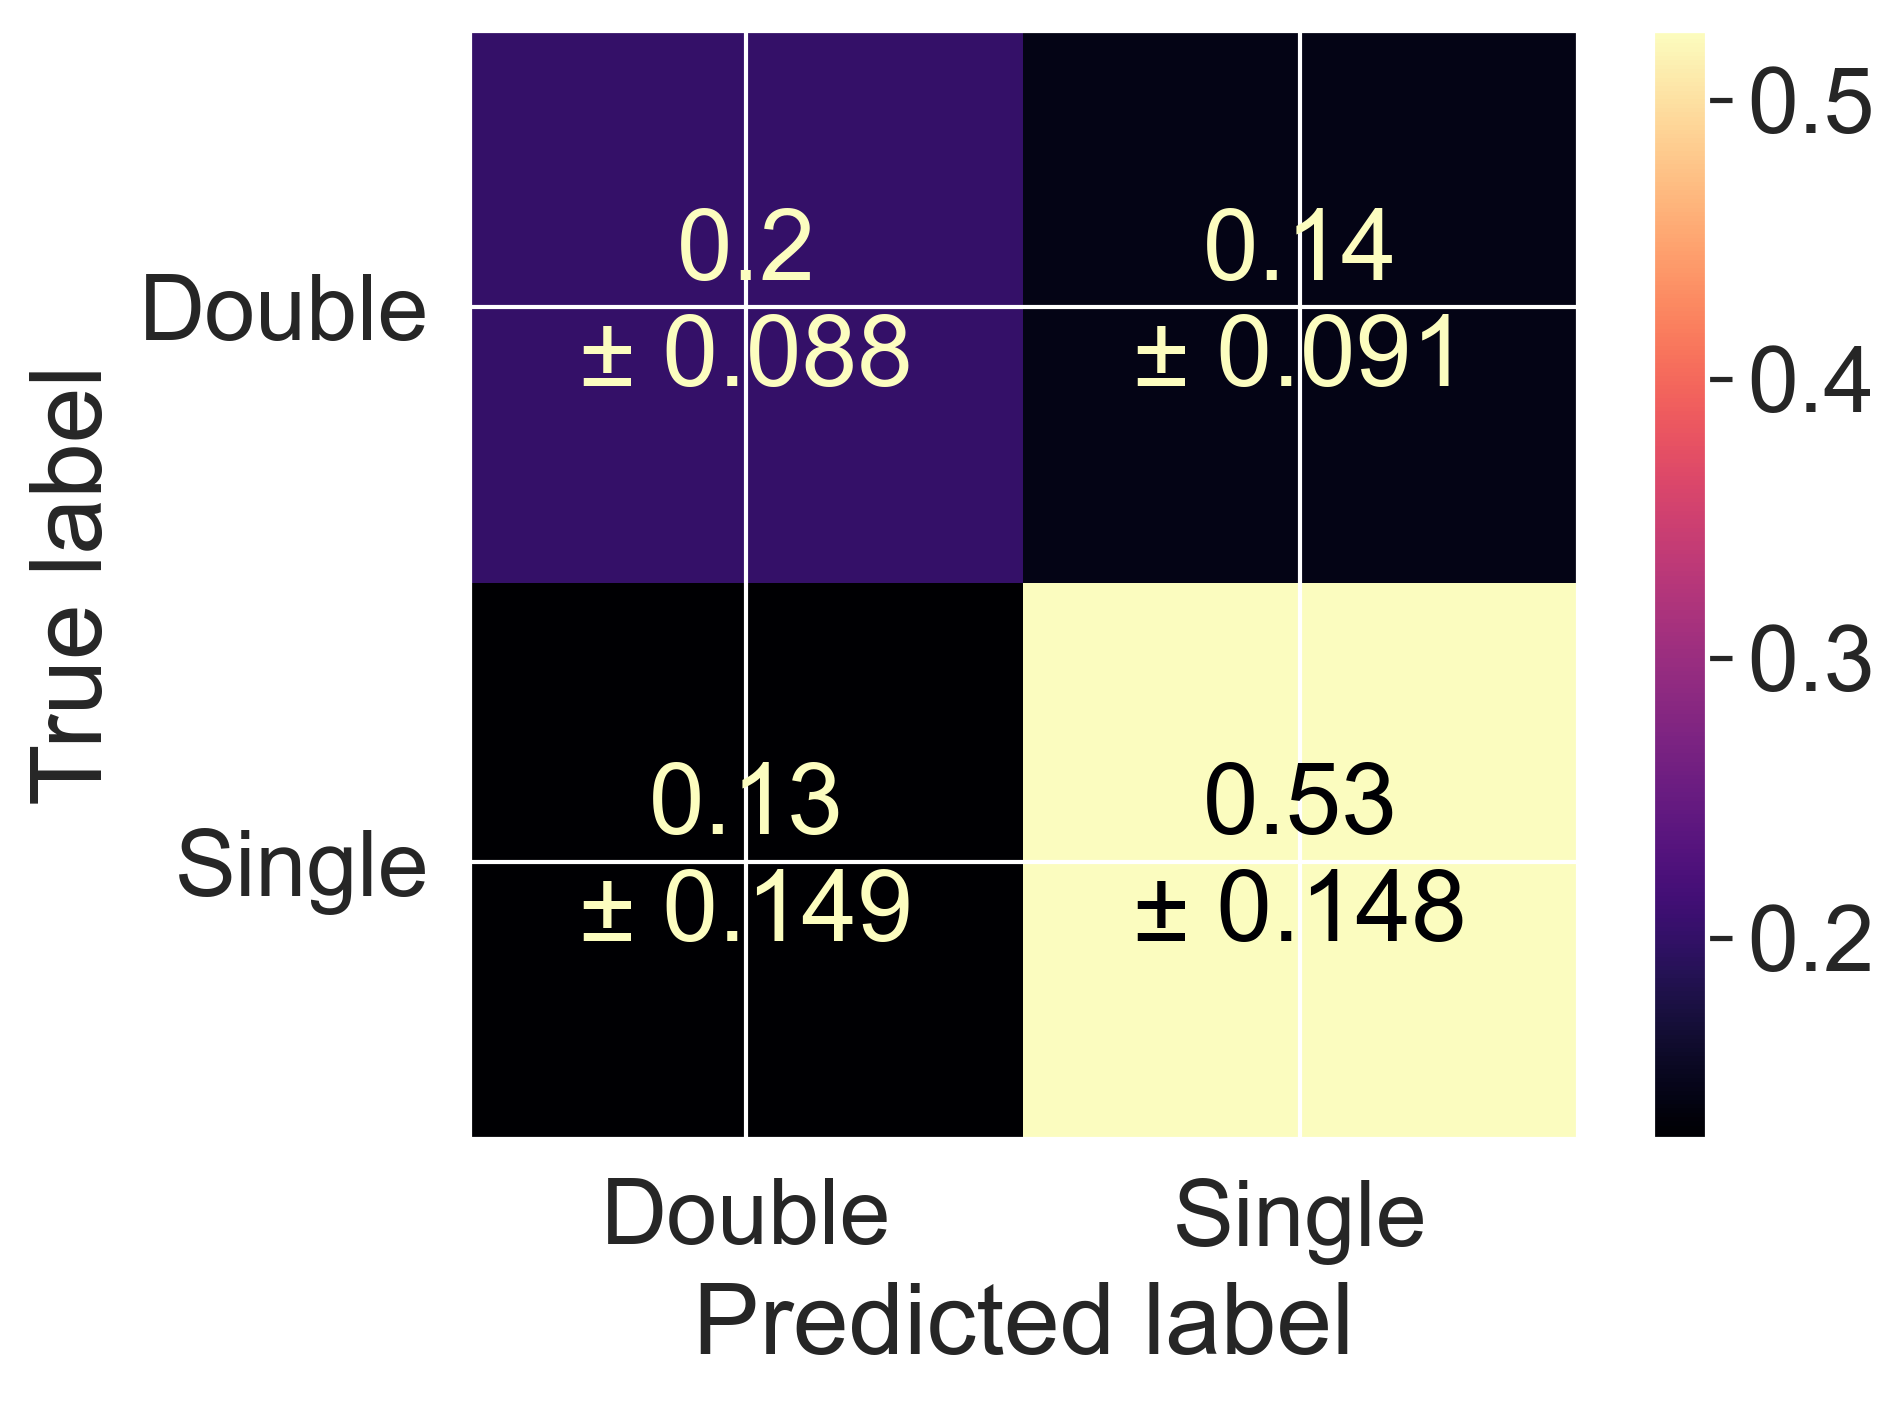

In [22]:
sns.set(font_scale = 2)
disp = metrics.ConfusionMatrixDisplay(np.mean(norm_confusion_matrices,axis=0),display_labels=["Double","Single"],)
disp.plot(cmap="magma")
new_text_mat = np.zeros_like(disp.text_)

for i,(row_text, row_std) in enumerate(zip(disp.text_,np.std(norm_confusion_matrices,axis=0))):
    for j,(text_object, std_dev) in enumerate(zip(row_text,row_std)):
        new_text = text_object._text +"\n"+u"\u00B1"+" "+ str(np.round(std_dev,decimals=3))
        text_object._text = new_text
        new_text_mat[i,j] = text_object

disp.text_ = new_text_mat
disp.figure_

plt.savefig(f"{out_revisions}/PLSR Axes Predictions COnfusion Matrix 5 Fold Cross Validation.pdf", format="pdf", bbox_inches="tight")

In [23]:
balanced_accuracies_normal = [metrics.balanced_accuracy_score(true,pred) for true, pred in all_test_y_pred_y]
balanced_accuracies_normal

[0.7482193732193732,
 0.5437675070028011,
 0.8605664488017428,
 0.7069716775599129,
 0.6122004357298475]

In [24]:
roc_auc_normal = [metrics.roc_auc_score(true,pred) for (true,_),pred in zip(all_test_y_pred_y,all_pred_y_nothresh)]
roc_auc_normal

[0.7934472934472935,
 0.5973389355742297,
 0.9738562091503268,
 0.8169934640522876,
 0.6506899055918663]

In [25]:
np.random.seed(42)

random_indices = np.random.choice(len(X),size = len(X), replace=False)

all_confusion_matrices_random = []
all_test_y_pred_y_random = []
all_pred_y_nothresh_random = []
X_np = X.to_numpy()
Y_np = Y.to_numpy()[random_indices]


for i, (train_index, test_index) in enumerate(kfold_split.split(X_np,Y_np)):
    train_X, test_X, train_Y, test_Y = X_np[train_index],X_np[test_index],Y_np[train_index],Y_np[test_index]
    my_plsr = PLSRegression(n_components=2, scale=False)
    my_plsr.fit(np.array(train_X), np.array(train_Y))

    test_pred = (my_plsr.predict(np.array(test_X)) > 0.5)[:,0]
    matrix = metrics.confusion_matrix(test_Y,test_pred,)
    all_confusion_matrices_random.append(matrix)
    all_test_y_pred_y_random.append((test_Y,test_pred))
    all_pred_y_nothresh_random.append(my_plsr.predict(np.array(test_X)))

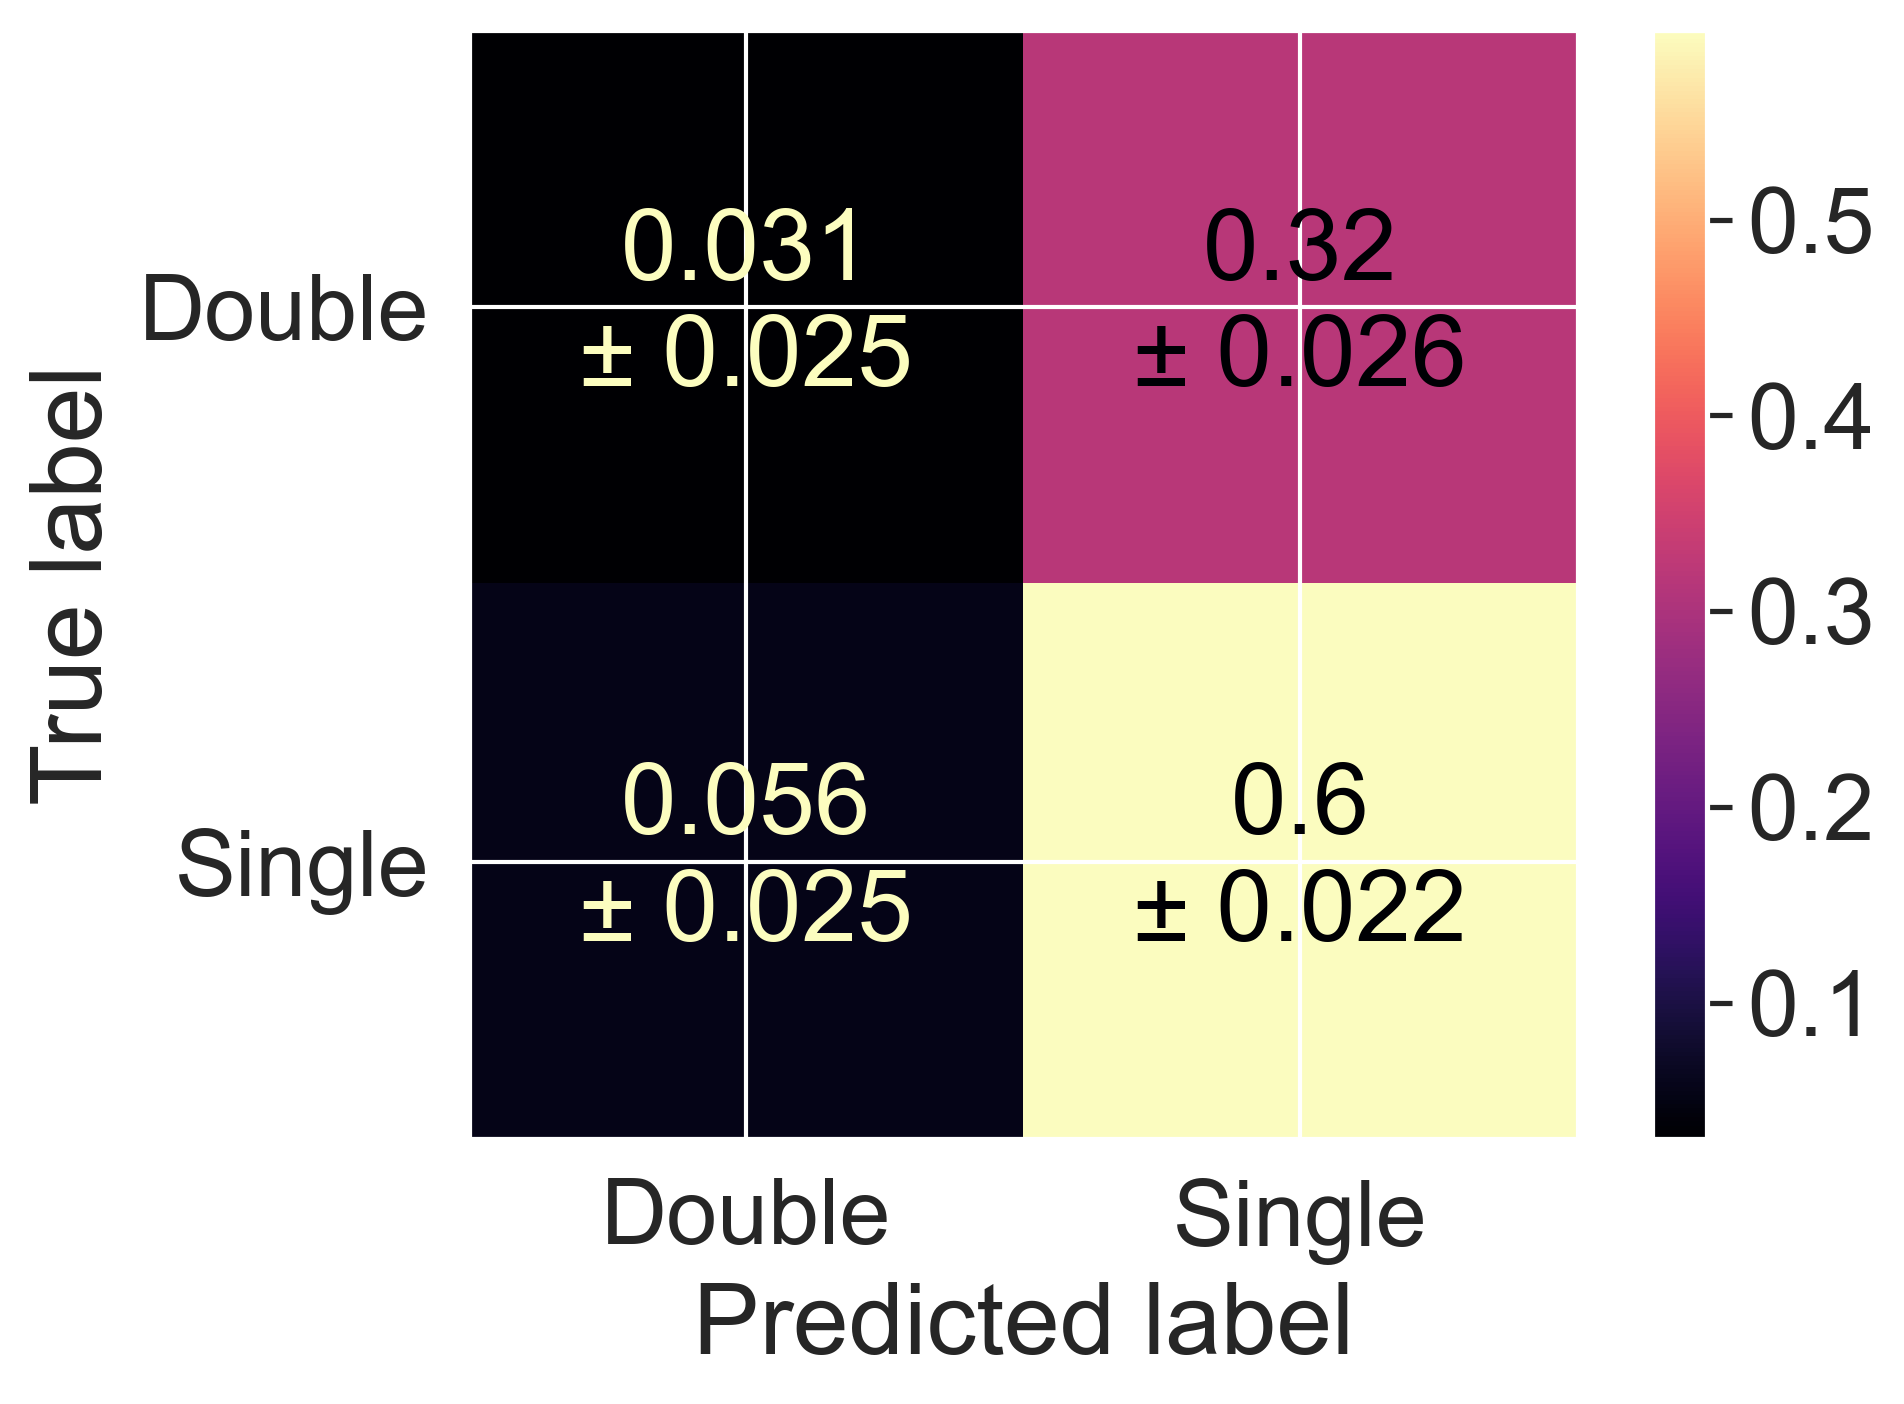

In [26]:
norm_confusion_matrices_random = [matrix/np.sum(matrix) for matrix in all_confusion_matrices_random]
sns.set(font_scale = 2)
disp_random = metrics.ConfusionMatrixDisplay(np.mean(norm_confusion_matrices_random,axis=0),display_labels=["Double","Single"])
disp_random.plot(cmap="magma")
new_text_mat = np.zeros_like(disp.text_)

for i,(row_text, row_std) in enumerate(zip(disp_random.text_,np.std(norm_confusion_matrices_random,axis=0))):
    for j,(text_object, std_dev) in enumerate(zip(row_text,row_std)):
        new_text = text_object._text +"\n"+u"\u00B1"+" "+ str(np.round(std_dev,decimals=3))
        text_object._text = new_text
        new_text_mat[i,j] = text_object

disp_random.text_ = new_text_mat
disp_random.figure_

plt.savefig(f"{out_revisions}/PLSR Axes Random Predictions Confusion Matrix 5 Fold Cross Validation.pdf", format="pdf", bbox_inches="tight")

In [27]:
balanced_accuracies_random = [metrics.balanced_accuracy_score(true,pred) for true, pred in all_test_y_pred_y_random]
balanced_accuracies_random

[0.4704415954415955,
 0.5080532212885154,
 0.4793028322440087,
 0.5065359477124183,
 0.542483660130719]

In [28]:
roc_auc_random = [metrics.roc_auc_score(true,pred) for (true,_),pred in zip(all_test_y_pred_y_random,all_pred_y_nothresh_random)]
roc_auc_random

[0.5448717948717948,
 0.5672268907563025,
 0.40885984023238925,
 0.5548293391430646,
 0.6463326071169209]

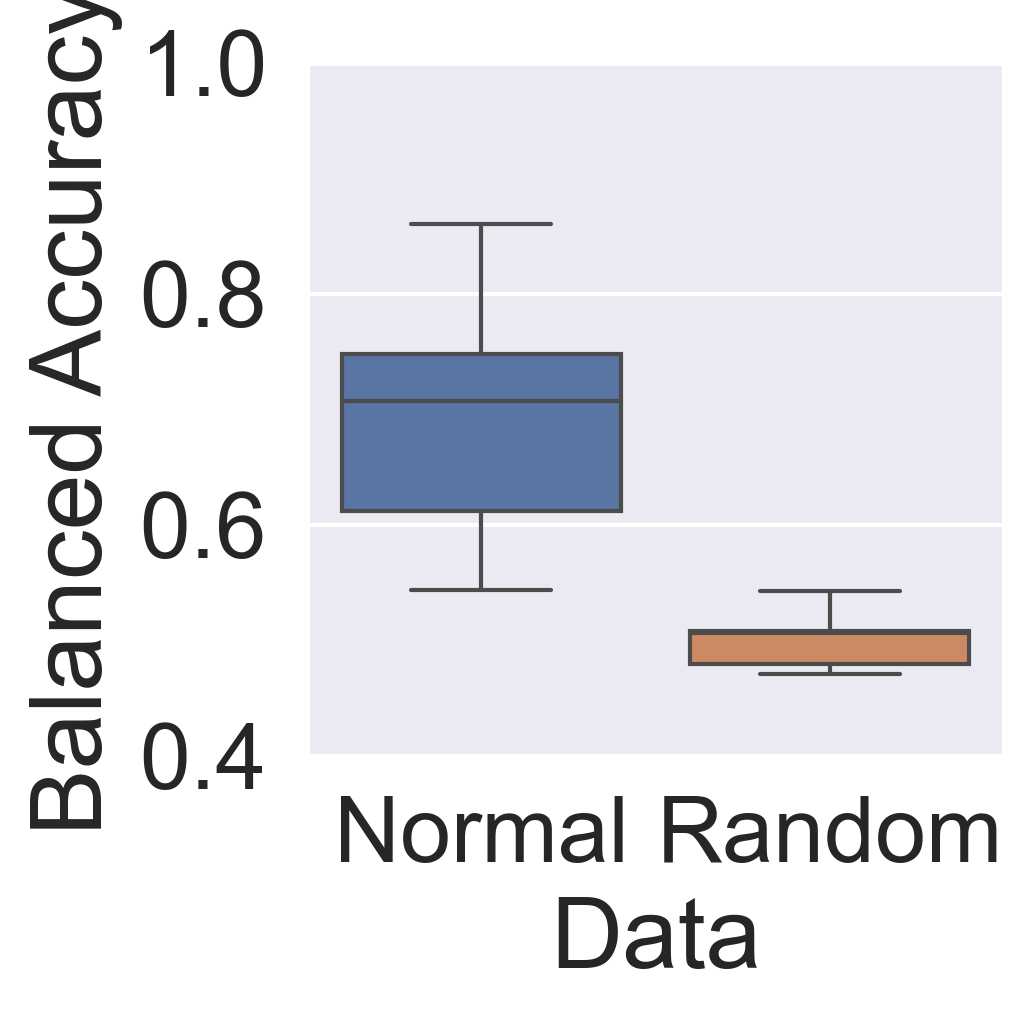

In [29]:
balanced_accuracies_df = pd.DataFrame(
    {
        "Balanced Accuracy":balanced_accuracies_normal+balanced_accuracies_random,
        "Data":["Normal" for i in range(5)] + ["Random" for i in range(5)]
    }
)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(balanced_accuracies_df,x="Data",y="Balanced Accuracy",hue="Data",ax=ax)
ax.set_ylim([0.4,1])
plt.savefig(f"{out_revisions}/PLSR Axes PLSR 5fold CV - balanced accuracy.pdf", format="pdf", bbox_inches="tight")

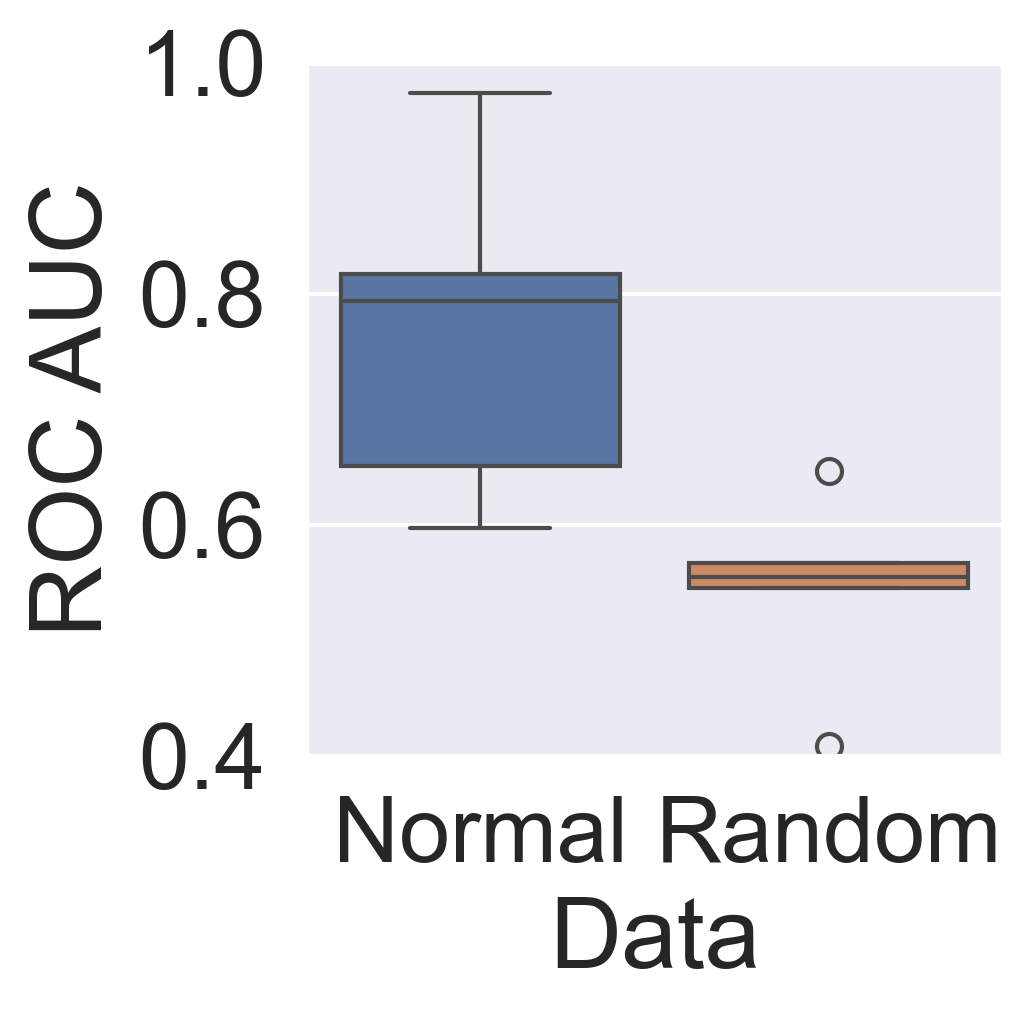

In [30]:
roc_auc_df = pd.DataFrame(
    {
        "ROC AUC":roc_auc_normal+roc_auc_random,
        "Data":["Normal" for i in range(5)] + ["Random" for i in range(5)]
    }
)
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.boxplot(roc_auc_df,x="Data",y="ROC AUC",ax=ax,hue="Data")
ax.set_ylim([0.4,1])
plt.savefig(f"{out_revisions}/PLSR Axes PLSR 5fold CV - ROC AUC.pdf", format="pdf", bbox_inches="tight")